# Kickstarter: Classification
Tests Include:
-KNN
-Logistic Regression
-Decision Trees
-Random Forest
-SVM
-Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy

from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, RandomTreesEmbedding
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import label_binarize, scale, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier

import datetime
import warnings
import os
%matplotlib inline

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
df = pd.read_pickle('data/kickstarter_data_ds2.pkl')
df['idx'] = df['id']
df = df.set_index('idx')
# df['state'] = df['state'].replace({'failed': 0, 'successful': 1})
# df = pd.read_sql_query('''SELECT * FROM kickstarter_data_ds2''',engine)
print(df.shape)
# pd.read_sql_query('''SELECT state, main_category, main_category, currency, currency, deadline, launched, usd_goal_real, usd_pledged_real FROM kickstarter_data_ds2 LIMIT 5''',engine)
df.head()

(163425, 18)


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,failed,games,Playing Cards,131,0.3,3387.000000,9999.000000,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,B.Y. Eidelman,16
2065169465,2065169465,Cotton-Top Pastries,successful,food,Small Batch,99,1.3,9858.000000,7500.000000,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,Holly Weist,5
1647325451,1647325451,Code Switch,successful,film_and_video,Horror,34,1.5,4611.000000,3000.000000,US,USD,32,2018-01-12,2017-12-11,2017-11-10,0,Alba Roland,23
727157486,727157486,Rain Dog Farm,failed,food,Farms,49,0.3,4741.000000,18000.000000,US,USD,38,2018-01-12,2017-12-05,2017-11-28,1,Charlie Wainger,9
1756145145,1756145145,WANGTA: a novel,successful,publishing,Fiction,13,1.0,427.185132,427.185132,CA,CAD,21,2018-01-12,2017-12-22,2017-12-18,0,D. H. de Bruin,22


In [6]:
start_date = datetime.datetime.strptime('2016-01-01', "%Y-%m-%d").date()

df = df[df['launched'] >= start_date] # filter from start date to current
df = df[['state','category_name','backers_count','usd_goal','country','currency','campaign_length',
        'staff_pick','blurb_length']]
df = df.dropna()

df.shape

(38401, 9)

In [7]:
df.columns

Index(['state', 'category_name', 'backers_count', 'usd_goal', 'country',
       'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object')

In [8]:
df_dummies = pd.get_dummies(df[['state','category_name', 'country','currency']],drop_first=True)
df = df_dummies.merge(df,how='inner',left_index=True, right_index=True)
print(df.shape)
print(df.columns)
df.info()

(38401, 183)
Index(['state_successful', 'category_name_Academic',
       'category_name_Accessories', 'category_name_Action',
       'category_name_Animals', 'category_name_Animation',
       'category_name_Anthologies', 'category_name_Apparel',
       'category_name_Apps', 'category_name_Architecture',
       ...
       'currency_USD', 'state', 'category_name', 'backers_count', 'usd_goal',
       'country', 'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object', length=183)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38401 entries, 1396766240 to 1094069811
Columns: 183 entries, state_successful to blurb_length
dtypes: float64(1), int64(4), object(4), uint8(174)
memory usage: 10.6+ MB


In [9]:
# removing all variables that cannot be known before a campaign is launched, such as # backers and $ pledged
df = df.dropna()
X = df.drop(['state_successful','state','category_name', 'backers_count', 'country', 'currency'], 1)
y = df['state_successful']

print(X.shape)

(38401, 177)


## Assumptions

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

k_range = list(range(1, 101))
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(26880, 177) (26880,)
(11521, 177) (11521,)


In [11]:
# https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

## Phase 1: Initial Check on All Models

In [12]:
# Define models to test
model_list = [['GaussianNB', GaussianNB()], 
                ['BernoulliNB', BernoulliNB(alpha=2.0, binarize=0.0, class_prior=None, fit_prior=True)], 
                ['MultinomialNB', MultinomialNB(alpha=0.5)],
                ['DecisionTree', DecisionTreeClassifier(criterion = 'gini', max_depth=2, splitter='best')], 
                ['KNN', KNeighborsClassifier(7)], # best k from KNN model below; scale data
                ['RandomForest', RandomForestClassifier(max_features='sqrt',n_estimators=1000)], 
                ['GradientBoost', GradientBoostingClassifier(n_estimators=500)],
                ['AdaBoost', AdaBoostClassifier(algorithm='SAMME.R',
                      base_estimator=DecisionTreeClassifier(criterion = 'gini', max_depth=2, splitter='best'),
                      n_estimators=2)],
                ['XGBoost', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
                       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
                       min_child_weight=11, missing=-999, n_estimators=500, nthread=4,
                       objective='reg:linear', reg_alpha=0, reg_lambda=1,
                       scale_pos_weight=1, seed=0, silent=1, subsample=0.8)],
                ['LogisticRegression', LogisticRegression(C=0.1, penalty='l1')]]           
#                 ['LogisticRegressionCV', LogisticRegressionCV()]] # scale data; F1 0.62
#                 ['SVM', SVC(probability=True)]] # scale data; F1 0.57

model_list_s = [['KNN', KNeighborsClassifier(38)], # best k from KNN model below; scale data
                ['LogisticRegression', LogisticRegression()]] # scale data
#                 ['LogisticRegressionCV', LogisticRegressionCV()]] # scale data
#                 ['SVM', SVC(probability=True)]] # scale data

# Calculate metrics for each model
roc = {}
results_dict = {}
for model in model_list:
    if model in model_list_s:
        X_train = X_train_s
        X_test = X_test_s
    
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision_1 = []
    precision_0 = []
    recall_1 = []
    recall_0 = []
    f1_1 = []
    f1_0 = []
    auc = []
        
    # Perform K-Fold CV and calculate metrics for each fold
    kf = KFold(5, random_state=42, shuffle=True) 
    for train_idx, test_idx in kf.split(X, y=y):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision_1.append(precision_score(y_test, y_pred ,pos_label=1))
        precision_0.append(precision_score(y_test, y_pred ,pos_label=0))
        recall_1.append(recall_score(y_test, y_pred, pos_label=1))
        recall_0.append(recall_score(y_test, y_pred, pos_label=0))
        f1_1.append(f1_score(y_test, y_pred, pos_label=1))
        f1_0.append(f1_score(y_test, y_pred, pos_label=0))
        auc.append(roc_auc_score(y_test, y_pred))
        
    # Calculate mean metric across K-folds
    mean_accuracy = np.mean(accuracy)
    mean_precision_1 = np.mean(precision_1)
    mean_precision_0 = np.mean(precision_0)
    mean_recall_1 = np.mean(recall_1)
    mean_recall_0 = np.mean(recall_0)
    mean_f1_1 = np.mean(f1_1)
    mean_f1_0 = np.mean(f1_0)
    mean_auc = np.mean(auc)
    
    # Capture TPR and FPR from last fold for plotting
    y_score = model.predict_proba(X_test)[:,1]
    roc[model_name] = roc_curve(y_test, y_score), mean_auc
    results_dict[model_name] = {"accuracy": mean_accuracy, "precision_s": mean_precision_1, "precision_f": mean_precision_0, "recall_s": mean_recall_1, "recall_f": mean_recall_0, "f1_s": mean_f1_1, "f1_f": mean_f1_0, "auc": mean_auc}
    
    # Print formatted results
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tAUC:', mean_auc)
    print('\n')
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))  

GaussianNB(priors=None)
	Accuracy: 0.57859560802
	AUC: 0.534658591702


[[ 428 4773]
 [  82 6238]]
             precision    recall  f1-score   support

          0       0.84      0.08      0.15      5201
          1       0.57      0.99      0.72      6320

avg / total       0.69      0.58      0.46     11521

BernoulliNB(alpha=2.0, binarize=0.0, class_prior=None, fit_prior=True)
	Accuracy: 0.733616873535
	AUC: 0.737199181511


[[4026 1175]
 [1894 4426]]
             precision    recall  f1-score   support

          0       0.68      0.77      0.72      5201
          1       0.79      0.70      0.74      6320

avg / total       0.74      0.73      0.73     11521

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)
	Accuracy: 0.612794028296
	AUC: 0.581318983204


[[1338 3863]
 [ 598 5722]]
             precision    recall  f1-score   support

          0       0.69      0.26      0.37      5201
          1       0.60      0.91      0.72      6320

avg / total       0.64      

In [13]:
# rc = pd.DataFrame(roc)
# rc

In [14]:
roc['AdaBoost'][0][1].mean()

0.34427215189873417

In [15]:
# roc.items()

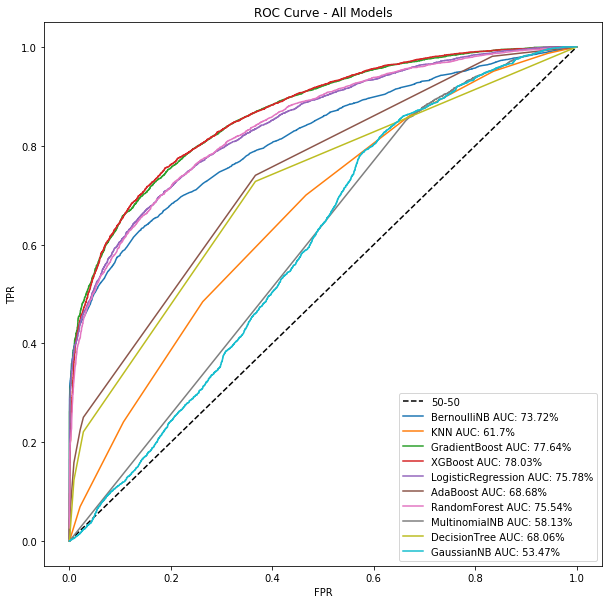

In [16]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(10, 10))
# colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange','darkorchid','bisque', 'darkgray']

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# Plot Classifier ROC Curves
for key, value in roc.items():
    label = '{}, AUC: {}%'.format(key, round(100*value[1],2))
    ax.plot(roc[key][0][0], roc[key][0][1], label=label)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve - All Models')
ax.legend(loc='best')
plt.savefig('charts/roc_ds2_p1.png')

In [17]:
rd = pd.DataFrame(results_dict).T
# rd['f1_success'] = rd['f1']
rd = rd.sort_values(['auc'],ascending=[False])
rd

,accuracy,auc,f1_f,f1_s,precision_f,precision_s,recall_f,recall_s
XGBoost,0.779707,0.780349,0.763335,0.793960,0.741083,0.815272,0.786964,0.773734
GradientBoost,0.775523,0.776423,0.759624,0.789449,0.735229,0.813081,0.785695,0.767152
LogisticRegression,0.753945,0.757811,0.745337,0.761987,0.699497,0.811719,0.797616,0.718006
RandomForest,0.756775,0.755352,0.733302,0.776450,0.726048,0.783009,0.740704,0.770000
BernoulliNB,0.733617,0.737199,0.724036,0.742555,0.680068,0.790216,0.774082,0.700316
AdaBoost,0.691954,0.686765,0.649896,0.724990,0.667342,0.710402,0.633340,0.740190
DecisionTree,0.685184,0.680594,0.644934,0.717237,0.656961,0.706931,0.633340,0.727848
KNN,0.625033,0.616951,0.562399,0.671982,0.594305,0.645985,0.533744,0.700158
MultinomialNB,0.612794,0.581319,0.374947,0.719522,0.691116,0.596974,0.257258,0.905380
GaussianNB,0.578596,0.534659,0.149886,0.719866,0.839216,0.566524,0.082292,0.987025
